[Cartola](http://cartola.globo.com) is a fantasy football league following the
Brazilian Championship A Series.

Cartola offers a public API to access data for the current round. A couple
of years ago, I created a script to automate data retrieval to a
[repository](https://github.com/assuncaolfi/tophat/tree/main), which now hosts
comprehensive historical data since 2022.

In this post, I will delve into the data for the 2022 season, formulate a mixed
integer linear program to draft the optimal team, and present initial concepts
for forecasting player scores using mixed effects linear models.

## The game

We begin the season with a budget of C$ 100, the game’s paper currency.

Each round is preceded by a market session, where players are assigned a value.
We are tasked with forming a team of 11 players plus a coach, all within our
budget and adhering to a valid formation. A captain must be chosen from among
the players, excluding the coach.

The market is available until the round starts. Players then earn scores based
on their real-life match performances. Our team's score is the aggregate of
our players' scores, with our captain’s score doubled in the 2022 season.

Following the conclusion of the round, player values are recalibrated based
on performance -— with increases for scores above their average and decreases for
below-average performances. Our budget for the next round is our previous
budget, plus the sum of our players' value variations.

## Data wrangling

Let's talk about data structures: each round has a market, and each market is a
list of players. A player is a structure like this:

In [1]:
# | label: data-wrangling-players
from pydantic import BaseModel, Field, field_validator
from typing import Dict, List
from urllib import request


class Player(BaseModel):
    round: int = Field(alias="rodada_id")
    player: int = Field(alias="atleta_id")
    team: int = Field(alias="clube_id")
    position: int = Field(alias="posicao_id")
    games: int = Field(alias="jogos_num")
    average: float = Field(alias="media_num")
    value: float = Field(alias="preco_num")
    score: float = Field(alias="pontos_num")
    appreciation: float = Field(alias="variacao_num")
    minimum: float | Dict | None = Field(alias="minimo_para_valorizar")

    @field_validator("minimum")
    @classmethod
    def dict_is_zero(cls, v: float | Dict | None):
        if v == {} or v is None:
            v = 0.0
        return v


class Market(BaseModel):
    players: List[Player] = Field(alias="atletas")


base_url = "https://raw.githubusercontent.com/assuncaolfi/tophat/main/2022/"
markets = []
for round in range(1, 39):
    url = base_url + f"{round:02}/atletas/mercado.json"
    data = request.urlopen(url).read()
    market = Market.model_validate_json(data)
    if round == 1:
        for player in market.players:
            player.round = 0
    markets.extend(market.players)

markets[0]

Player(round=0, player=42234, team=264, position=1, games=0, average=0.0, value=10.0, score=0.0, appreciation=0.0, minimum=4.53)

Let's get the list of markets for 2022 and flatten it into a single DataFrame:

In [76]:
# | label: data-wrangling-dataframe
import polars as pl

players = (
    pl.DataFrame(markets)
    .with_columns(round=pl.col("round") + 1)
    .sort("round", "player")
)
pl.Config(
    tbl_dataframe_shape_below=True,
    tbl_formatting="ASCII_BORDERS_ONLY_CONDENSED",
    tbl_hide_column_data_types=True,
    tbl_rows=6,
)
print(players)

+-------------------------------------------------------------------------------+
| round   player   team   position   …   value   score   appreciation   minimum |
+===============================================================================+
| 1       37424    1371   6          …   3.0     0.0     0.0            0.0     |
| 1       37646    314    3          …   5.0     0.0     0.0            2.3     |
| 1       37656    266    1          …   9.0     0.0     0.0            4.08    |
| …       …        …      …          …   …       …       …              …       |
| 38      121398   354    4          …   1.0     0.0     0.0            0.0     |
| 38      121399   354    4          …   1.0     0.0     0.0            0.0     |
| 38      121400   354    5          …   1.0     0.0     0.0            0.0     |
+-------------------------------------------------------------------------------+
shape: (30_063, 10)


Now, let's focus on a specific `player` to illustrate our data while we wrangle
it:

In [61]:
# | label: data-wrangling-example
def filter_example(markets: pl.DataFrame, columns: List[str]):
    example = players.filter(pl.col("player") == 42234).select(
        ["round", "player"] + columns
    )
    print(example)


filter_example(players, players.columns[2:])

+-------------------------------------------------------------------------------+
| round   player   team   position   …   value   score   appreciation   minimum |
+===============================================================================+
| 1       42234    264    1          …   10.0    0.0     0.0            4.53    |
| 2       42234    264    1          …   7.93    2.0     -2.07          5.52    |
| 3       42234    264    1          …   10.44   11.0    2.51           4.75    |
| …       …        …      …          …   …       …       …              …       |
| 36      42234    264    1          …   11.51   0.0     0.03           3.63    |
| 37      42234    264    1          …   12.68   0.0     1.17           9.29    |
| 38      42234    264    1          …   11.06   0.0     -1.62          1.37    |
+-------------------------------------------------------------------------------+
shape: (38, 10)


### Filtering participation

Players will show up in the market for many rounds that they do not participate
in. However, for our analysis, we are only interested in players that actually
played a game in the round.

Each player has a `status` field intended to indicate their participation in the
round. However, this field is often inaccurate, likely due to the API data being
updated before the round.

One solution is to keep only rows where there is an increase in the number of
`games` the player has played:

In [62]:
# | label: data-wrangling-round-participation
players = players.filter(
    pl.col("games") != pl.col("games").shift(1).over("player").fill_null(-1)
)
filter_example(markets, ["games"])

+------------------------+
| round   player   games |
+========================+
| 1       42234    0     |
| 2       42234    1     |
| 3       42234    2     |
| …       …        …     |
| 36      42234    28    |
| 37      42234    29    |
| 38      42234    30    |
+------------------------+
shape: (31, 3)


### Imputing scores

Similarly, the player `score` field is often inaccurate, likely for the same
reasons as the `status` field. Fortunately, the `average` field is reliable,
allowing us to recover the `score`:

$$
\begin{align*}
\mathrm{Average}(\mathbf{s}_{1:t})
= \frac{\mathrm{Average}(\mathbf{s}_{1:(t-1)}) + s_t}{2} \\
s_t
= 2\mathrm{Average}(\mathbf{s}_{1:t}) - \mathrm{Average}(\mathbf{s}_{1:(t-1)}),
\end{align*}
$$

where $\mathbf{s}$ is the vector of scores for a given player across all rounds.

In [63]:
# | label: data-wrangling-missing-scores
# TODO make this better
players = players.with_columns(
    average=pl.col("average").shift(-1).over("player").fill_null(pl.col("average"))
).with_columns(
    score=2 * pl.col("average")
    - pl.col("average").shift(1).over("player").fill_null(pl.col("average")),
)
filter_example(players, ["score", "average"])

+----------------------------------+
| round   player   score   average |
+==================================+
| 1       42234    2.0     2.0     |
| 2       42234    11.0    6.5     |
| 3       42234    9.5     8.0     |
| …       …        …       …       |
| 36      42234    5.1     4.96    |
| 37      42234    4.62    4.79    |
| 38      42234    4.79    4.79    |
+----------------------------------+
shape: (31, 4)


### Adding fixtures

Let's fetch the list of fixtures to enrich our dataset. A fixture is an object
like:

In [65]:
# | label: data-wrangling-fixtures
class Fixture(BaseModel):
    round: int = Field(default=0)
    home: int = Field(alias="clube_casa_id")
    away: int = Field(alias="clube_visitante_id")


class Round(BaseModel):
    round: int = Field(alias="rodada")
    fixtures: List[Fixture] = Field(alias="partidas")


fixtures = []
for round in range(1, 39):
    url = base_url + f"{round:02}/partidas.json"
    data = request.urlopen(url).read()
    round = Round.model_validate_json(data)
    for fixture in round.fixtures:
        fixture.round = round.round
    fixtures.extend(round.fixtures)
fixtures[0]

Fixture(round=1, home=282, away=285)

Let's consolidate these fixtures into a single DataFrame and then pivot them
into a long format:

In [66]:
# | label: data-wrangling-fixtures-long
fixtures = (
    pl.DataFrame(fixtures)
    .rename({"home": "team", "away": "versus"})
    .with_columns(home=pl.lit(1))
)
mirrored = fixtures.rename({"team": "versus", "versus": "team"}).with_columns(
    home=pl.lit(0)
)
fixtures = pl.concat([fixtures, mirrored], how="diagonal")
print(fixtures)

+------------------------------+
| round   team   versus   home |
+==============================+
| 1       282    285      1    |
| 1       266    277      1    |
| 1       276    293      1    |
| …       …      …        …    |
| 38      276    290      0    |
| 38      294    1371     0    |
| 38      263    293      0    |
+------------------------------+
shape: (760, 4)


Finally, let's join this data to our dataset:

In [67]:
# | label: data-wrangling-fixtures-join
players = players.join(fixtures, on=["round", "team"], how="inner")
filter_example(players, ["team", "versus", "home"])

+---------------------------------------+
| round   player   team   versus   home |
+=======================================+
| 1       42234    264    263      0    |
| 2       42234    264    314      1    |
| 3       42234    264    275      0    |
| …       …        …      …        …    |
| 36      42234    264    354      1    |
| 37      42234    264    294      0    |
| 38      42234    264    282      1    |
+---------------------------------------+
shape: (31, 5)


### Aligning variables

In our subsequent analysis, the `average` field will exclude the `score` from
the given round. Additionally, the `appreciation` field will be calculated in
relation to the round's `score`.

In [68]:
# | label: data-wrangling-lookahead-variables
players = players.with_columns(
    average=pl.col("average").shift(1).over("player").fill_null(0.0),
    appreciation=pl.col("appreciation").shift(-1).over("player").fill_null(0.0),
)
filter_example(players, ["average", "value", "score", "appreciation"])

+---------------------------------------------------------+
| round   player   average   value   score   appreciation |
+=========================================================+
| 1       42234    0.0       10.0    2.0     -2.07        |
| 2       42234    2.0       7.93    11.0    2.51         |
| 3       42234    6.5       10.44   9.5     1.25         |
| …       …        …         …       …       …            |
| 36      42234    4.82      11.51   5.1     1.17         |
| 37      42234    4.96      12.68   4.62    -1.62        |
| 38      42234    4.79      11.06   4.79    0.0          |
+---------------------------------------------------------+
shape: (31, 6)


## Team picking

Now let's solve the problem of picking the best team a given market. Let $
\mathcal{F}$ be the set of valid formations, then for each formation $f \in
\mathcal{F}$, solve:

$$
\begin{equation*} \begin{array}{ll@{}ll}
\text{maximize} & \displaystyle \hat{\mathbf{s}}^T \mathbf{x}, & \mathbf{x} \in \{\mathbf{0}, \mathbf{1}\} \\
\text{subject to}
& \displaystyle \mathbf{v}^T \mathbf{x} \leq b \\
& \displaystyle \mathbf{P}^T \mathbf{x} = f, \\
\end{array} \end{equation*}
$$

where

$\mathbf{x}$ is a variable vector of player picks in the market;
$\hat{\mathbf{s}}$ is the vector of predicted player scores in the market;
$b$ is our available budget for that round;
$\mathbf{P}$ is the matrix of dummy-encoded player formations in the market.

Finally, take the solution with the highest objective.

In [10]:
# | echo: true
# | label: team-picking-problem
import numpy as np
import pulp


class Formation(BaseModel):
    goalkeeper: int = Field(alias="gol")
    defender: int = Field(alias="zag")
    winger: int = Field(alias="lat")
    midfielder: int = Field(alias="mei")
    forward: int = Field(alias="ata")
    coach: int = Field(alias="tec")


class Problem(BaseModel):
    scores: List[float]
    values: List[float]
    budget: float
    positions: List[List[int]]
    formations: List[Formation]

    def solve(self) -> List[pulp.LpSolution]:
        formations = [list(f.model_dump().values()) for f in self.formations]
        problems = [self.construct(f) for f in formations]
        [p.solve(pulp.COIN(msg=False)) for p in problems]
        objectives = [p.objective.value() for p in problems]
        best = np.argmax(np.array(objectives))
        solution = problems[best]
        variables = [v.value() for v in solution.variables()]
        picks = np.array(variables)
        return picks

    def construct(self, formation: List[int]) -> pulp.LpProblem:
        n = len(self.scores)
        m = len(formation)
        problem = pulp.LpProblem("team_picking", pulp.LpMaximize)
        indexes = ["pick_" + str(i).zfill(len(str(n))) for i in range(n)]
        picks = [pulp.LpVariable(i, cat=pulp.const.LpBinary) for i in indexes]
        problem += pulp.lpDot(picks, self.scores)
        problem += pulp.lpDot(picks, self.values) <= self.budget
        for i in range(m):
            problem += pulp.lpDot(picks, self.positions[i]) == formation[i]
        return problem

### Backtesting

By solving the team picking problem for all rounds, we can backtest our
performance in the season. Before backtesting, let's get the set of valid
formations  $\mathcal{F}$:

In [11]:
# | label: team-picking-formations
from pydantic import RootModel


class MetaFormation(BaseModel):
    id: int = Field(alias="esquema_id")
    name: str = Field(alias="nome")
    formation: Formation = Field(alias="posicoes")


class MetaFormations(RootModel):
    root: List[MetaFormation]


url = base_url + "38/esquemas.json"
data = request.urlopen(url).read()
meta_formations = MetaFormations.model_validate_json(data).root
formations = [m.formation for m in meta_formations]
formations

[Formation(goalkeeper=1, defender=3, winger=0, midfielder=4, forward=3, coach=1),
 Formation(goalkeeper=1, defender=3, winger=0, midfielder=5, forward=2, coach=1),
 Formation(goalkeeper=1, defender=2, winger=2, midfielder=3, forward=3, coach=1),
 Formation(goalkeeper=1, defender=2, winger=2, midfielder=4, forward=2, coach=1),
 Formation(goalkeeper=1, defender=2, winger=2, midfielder=5, forward=1, coach=1),
 Formation(goalkeeper=1, defender=3, winger=2, midfielder=3, forward=2, coach=1),
 Formation(goalkeeper=1, defender=3, winger=2, midfielder=4, forward=1, coach=1)]

Knowing our formation constraints, we're ready to backtest. Starting with a
budget of C$ 100, for each round let's:

1. Predict each player's score based on their performance on previous rounds;
2. Pick the team with the best total score;
3. Add the sum of the team player's appreciation to our budget.

In [77]:
# | echo: true
# | label: team-picking-backtest
from typing import Callable
import polars as pl


def backtest(
    players: pl.DataFrame, predict: Callable, initial_budget: float = 100.0
) -> pl.DataFrame:
    rounds = players.get_column("round").max()
    budget = [None] * rounds
    teams = [None] * rounds
    budget[0] = initial_budget
    appreciation = 0
    for round in range(rounds):
        if round > 0:
            budget[round] = budget[round - 1] + appreciation
        data = players.filter(pl.col("round") < round + 1)
        candidates = players.filter(pl.col("round") == round + 1)
        candidates = predict(data, candidates)
        problem = Problem(
            scores=candidates.get_column("prediction"),
            values=candidates.get_column("value"),
            positions=candidates.get_column("position").to_dummies(),
            budget=budget[round],
            formations=formations,
        )
        picks = problem.solve()
        team = candidates.filter(picks == 1)
        teams[round] = team
        appreciation = team.get_column("appreciation").sum()
    teams = pl.concat(teams)
    return teams


Before exploring predictions, we'll begin with a few hypothetical backtests
using actual observed scores for team selection. Backtesting this strategy, this
is our team in the first round:

In [69]:
# | label: team-picking-backtest-first-team
def predict_score(data: pl.DataFrame, candidates: pl.DataFrame) -> pl.DataFrame:
    prediction = candidates.get_column("score")
    candidates = candidates.with_columns(prediction=prediction)
    return candidates


teams = backtest(players, predict_score)
print(teams.filter(pl.col("round") == 1).sort("position"))

+-----------------------------------------------------------------------------+
| round   player   team   position   …   minimum   versus   home   prediction |
+=============================================================================+
| 1       71571    356    1          …   3.19      1371     1      11.0       |
| 1       42145    294    2          …   2.75      290      1      15.8       |
| 1       105584   264    2          …   2.75      263      0      10.5       |
| …       …        …      …          …   …         …        …      …          |
| 1       89840    276    5          …   5.42      293      1      27.1       |
| 1       104530   294    5          …   2.3       290      1      11.0       |
| 1       97341    276    6          …   0.0       293      1      9.52       |
+-----------------------------------------------------------------------------+
shape: (12, 13)


And we can plot out cumulative performance during the season:

/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)


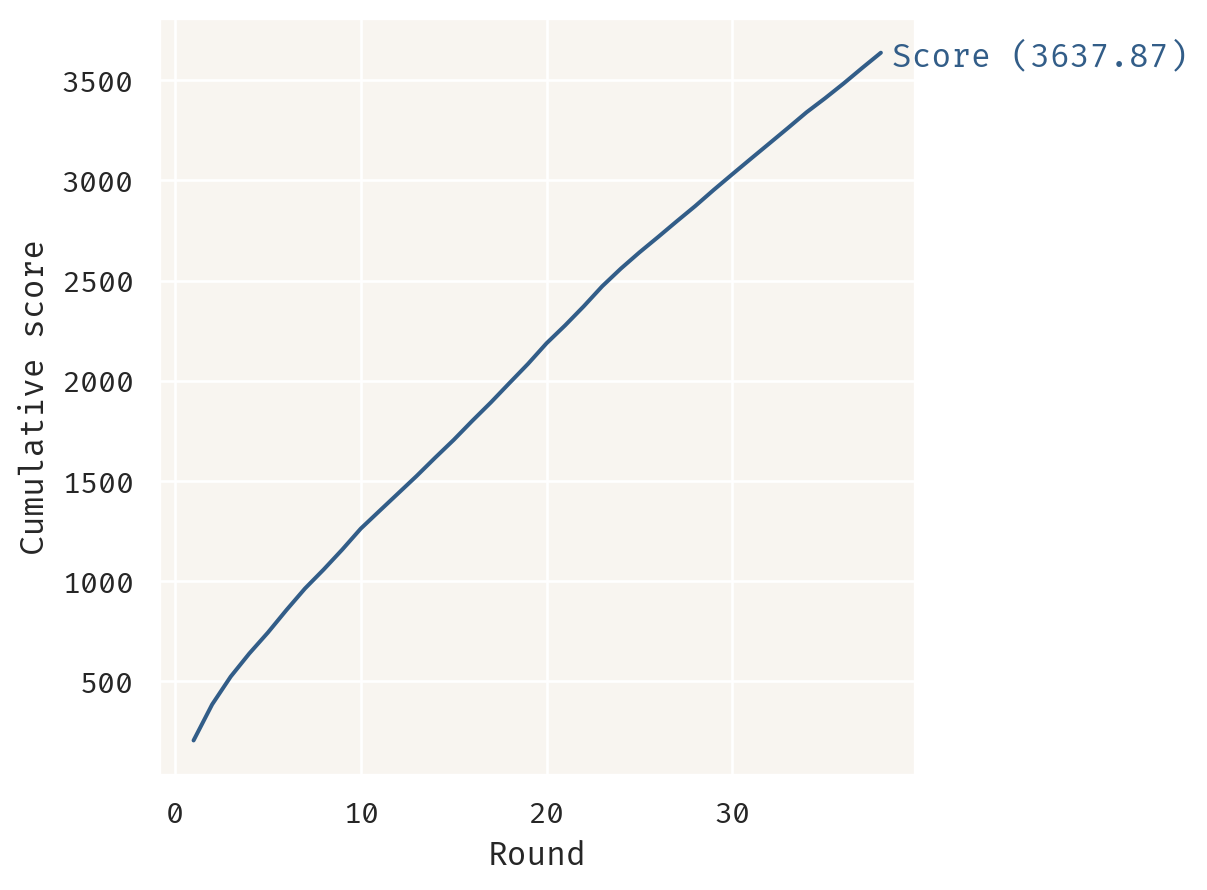

In [14]:
# | label: team-picking-backtest-score
# | warning: false
from blog import theme
import seaborn.objects as so


def summarize(teams: pl.DataFrame, model: str) -> pl.DataFrame:
    captains = (
        teams.filter(pl.col("position") != 6)
        .filter(pl.col("prediction") == pl.col("prediction").over("round").max())
        .with_columns(captain=2.0)
        .select("round", "player", "captain")
    )  # TODO review
    campaign = (
        teams.join(captains, on=["round", "player"], how="left")
        .with_columns(score=pl.col("score") * pl.col("captain").fill_null(1.0))
        .group_by("round")
        .agg(score=pl.col("score").sum())
        .with_columns(score=pl.col("score").cum_sum())
    )
    score = campaign.get_column("score").tail(1).round(2).item()
    label = f"{model} ({score})"
    campaign = campaign.with_columns(label=pl.lit(label))
    return campaign


def add_line(
    fig: so.Plot,
    campaign: pl.DataFrame,
    linestyle: str = "solid",
    valign: str = "center_baseline",
) -> so.Plot:
    text = campaign.tail(1)
    fig = fig.add(
        so.Line(linestyle=linestyle),
        data=campaign,
        legend=False,
    ).add(
        so.Text({"clip_on": False}, halign="left", valign=valign),
        data=text,
    )
    return fig


season = summarize(teams, "Score")
theme.set()
fig = so.Plot(season, x="round", y="score", color="label", text="label").label(
    x="Round", y="Cumulative score"
)
fig = add_line(fig, season)
fig

This might seem like a perfect campaign at first, but it's possible that, early
in the season, we didn't have enough budget to pick the best scoring teams. To
test this hypothesis, we backtest the same strategy with unlimited budget from
the start:

/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)


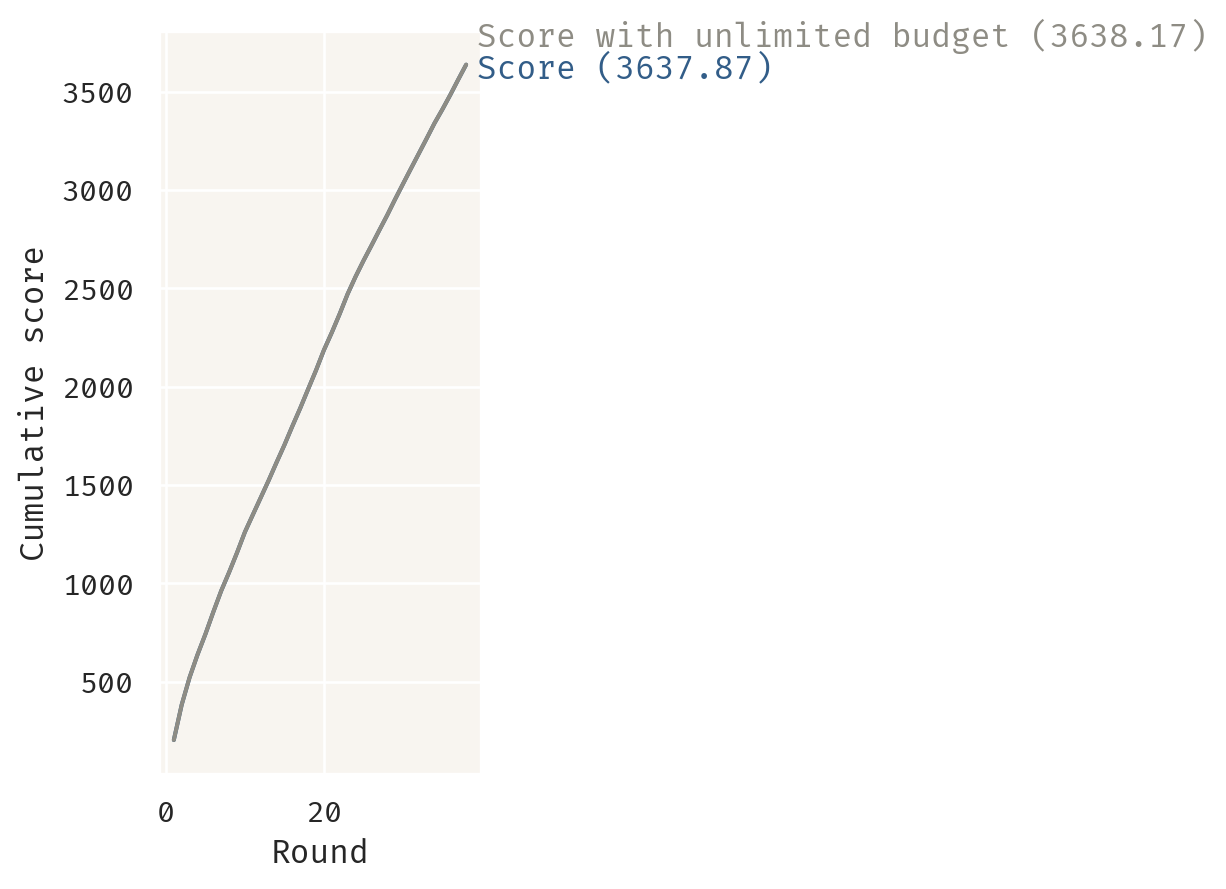

In [15]:
# | label: team-picking-backtest-score-unlimited-budget
# | warning: false
def add_backtest(
    fig: so.Plot,
    teams: pl.DataFrame,
    model: str,
    valign: str = "center_baseline",
) -> so.Plot:
    campaign = summarize(teams, model)
    fig = add_line(fig, campaign, valign=valign)
    return fig


teams = backtest(players, predict_score, initial_budget=1000.0)
add_backtest(fig, teams, "Score with unlimited budget", valign="bottom")

Both runs are nearly identical, which is evidence that focusing on appreciation
is not so important if we have accurate predictions for the scores. If we
predict scores perfectly, we get a near perfect run.

To put our backtests into perspective,
[the 2022 season champion had a total score of 3434.37](https://ge.globo.com/cartola/noticia/2022/12/03/cartola-2022-com-larga-vantagem-mosquito-bar-8-vence-liga-premiada-meliuz-e-fatura-r-20-mil.ghtml).
This is very impressive and not very far from the near perfect run.

/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `

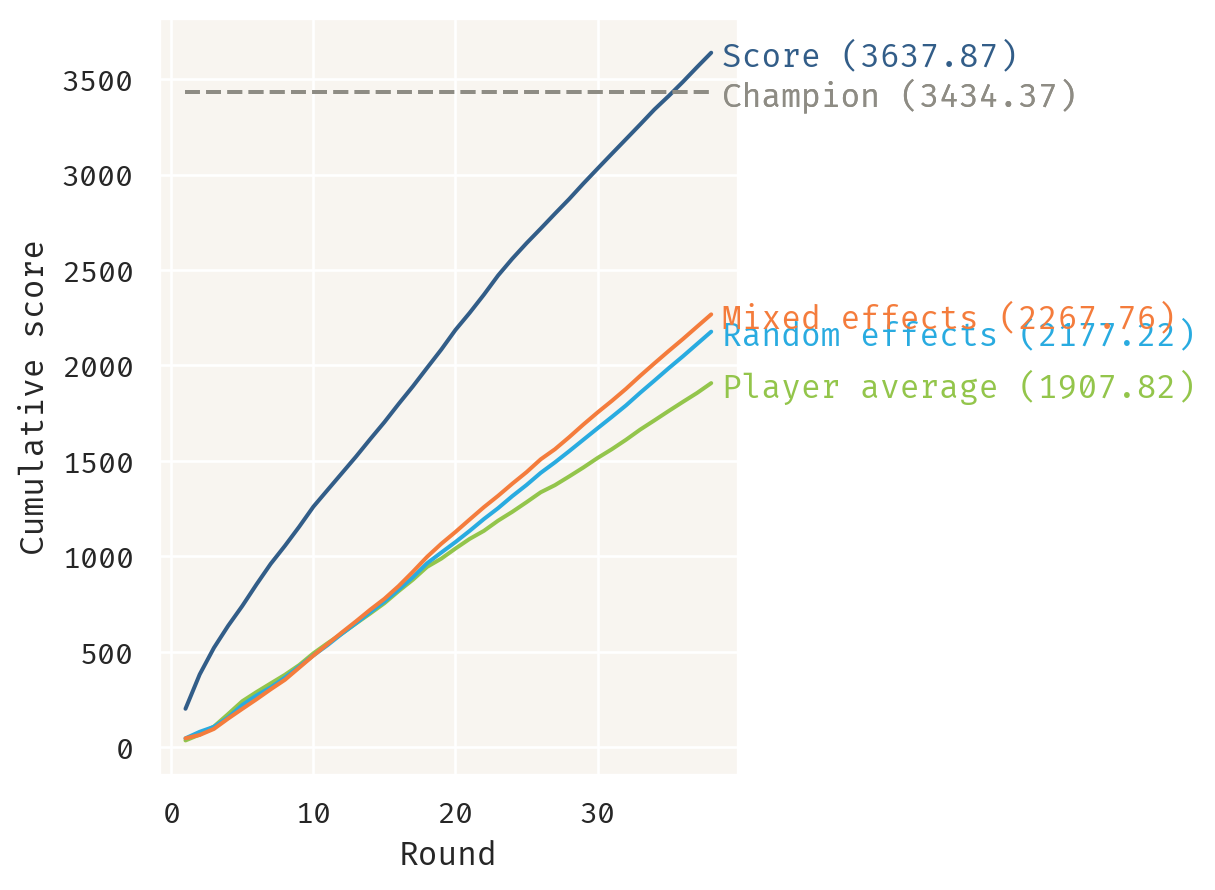

In [20]:
# | label: team-picking-backtest-champion
# | warning: false
champion = players.unique("round").with_columns(
    score=pl.lit(3434.37), label=pl.lit("Champion (3434.37)")
)
fig = add_line(fig, champion, linestyle="dashed")
fig

## Score prediction

For each round, we must predict $\hat{s}$, the vector of score predictions,
using data from previous rounds.

However, during the first round, we don't have any previous data to train our
model. In this case, we need to include prior information. One way to do that
would be to use data from previous seasons. However, we know a variable where
this information is already encoded: the player `value`. Each season starts with
players valued according to their past performance. Knowing this, all our models
start with $\hat{s} = v$ in the first round.

Let's use Bambi [@Capretto2022] and its default priors to fit our models. We
won't  delve into convergence diagnostics, since we are more interested in the
average of the predictive posteriors and the backtest itself is measure of the
prediction quality.

One question that arises here is: why not use non-parametric models such
as gradient boosted trees or neural nets? After some experimentation, I
concluded they are not a good fit for this problem: either because they
assume independence between observations, or because they are too data hungry.
Also, tuning these models for backtests might lead us into a rabbit hole
[@Bailey2013].

### Player average

$$
\begin{align*}
\mathbf{\hat{s}} = \mathbf{Z} \mathbf{\beta} \\
\mathbf{s} \sim N(\mathbf{\hat{s}}, \sigma),
\end{align*}
$$

where
$\mathbf{Z}$ is a dummy-encoded matrix of players;
$\mathbf{\beta}$ is a vector of parameters for each player.

In this model, $\mathbf{\beta}$ is simply a vector of player averages. Let's
also consider that players that show up in the middle of the season have an
average of zero before their first round. This will be our baseline model.

/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/Users/assuncaolfi/Projects/site/blog/fantasy-football/.venv/lib/python3.11/site-packages/seaborn/_core/plot.py:1644: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `

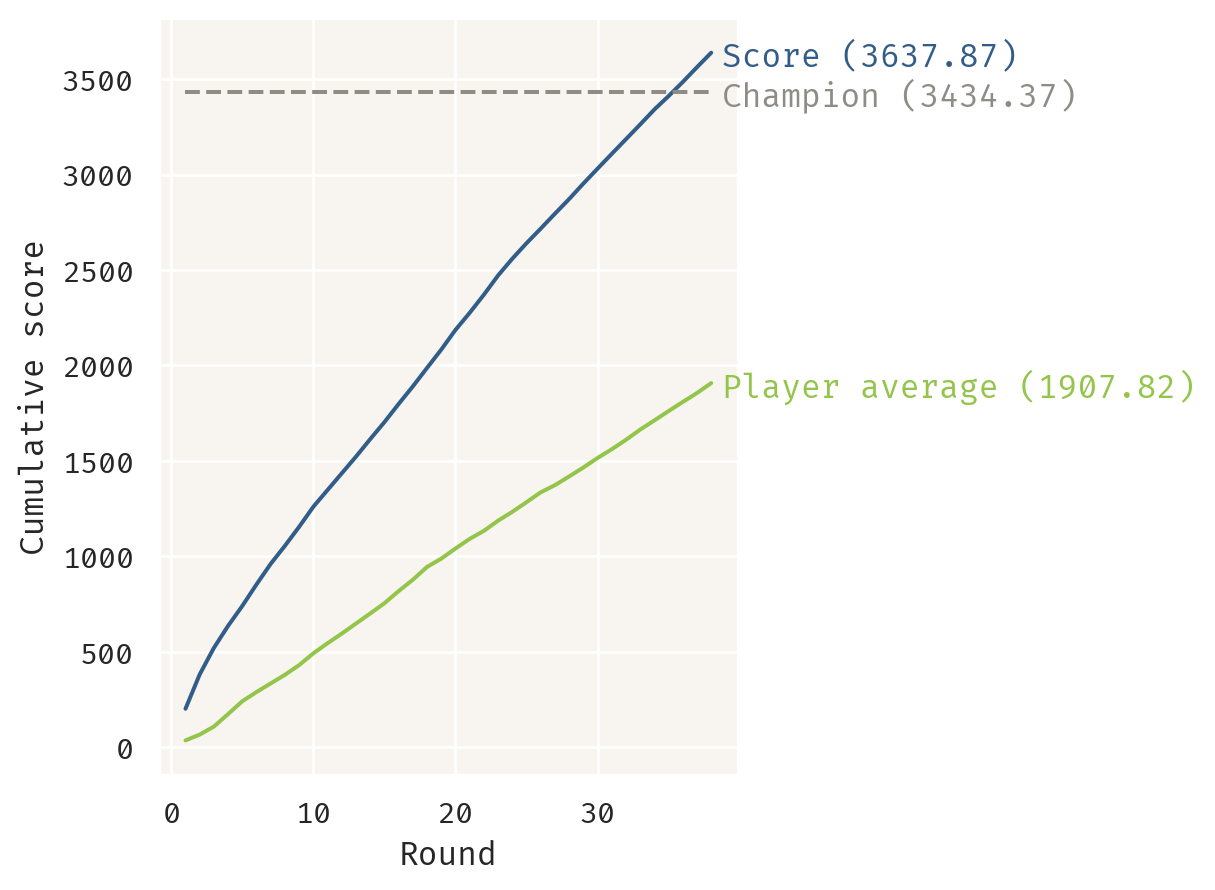

In [17]:
# | label: score-prediction-player-average
# | warning: false
def predict_average(data: pl.DataFrame, candidates: pl.DataFrame):
    candidates = candidates.with_columns(
        prediction=pl.when(pl.col("round") == 1)
        .then(pl.col("value"))
        .otherwise(pl.col("average"))
    )
    return candidates


teams = backtest(players, predict_average)
fig = add_backtest(fig, teams, "Player average")
fig

### Player random effects

$$
\begin{align*}
\mathbf{\hat{s}} = \alpha + \mathbf{Z} \mathbf{b} \\
\mathbf{b} \sim N(0, \sigma_b),
\end{align*}
$$

where
$\alpha$ is an intercept and
$\mathbf{b}$ is a vector of player random effects.

This model performs significantly better than the average model, possibly
because of the partial pooling between the random effects, that pulls large
effects towards the overall mean [@clark2019shrinkage]. In our dataset, it's
common for players that played one or two games to have large averages by
chance.

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Compiling...
Compilation time = 0:00:15.348142
Sampling...
Sampling time = 0:00:03.736367
Transforming variables...
Transformation time = 0:00:00.106630
Compiling...
Compilation time = 0:00:02.471332
Sampling...
Sampling time = 0:00:02.263076
Transforming variables...
Transformation time = 0:00:00.099559
Compiling...
Compilation time = 0:00:00.570329
Sampling...
Sampling time = 0:00:02.436223
Transforming variables...
Transformation time = 0:00:00.090894
Compiling...
Compilation time = 0:00:00.581795
Sampling...
Sampling time = 0:00:02.499836
Transforming variables...
Transformation time = 0:00:00.087544
Compiling...
Compilation time = 0:00:00.474472
Sampling...
Sampling time = 0:00:02.679640
Transforming variables...
Transformation time = 0:00:00.086805
Compiling...
Compilation time = 0:00:00.597276
Sampling...
Sampling time = 0:00:02.730077
Transforming variables...
Transformation time = 0:00:0

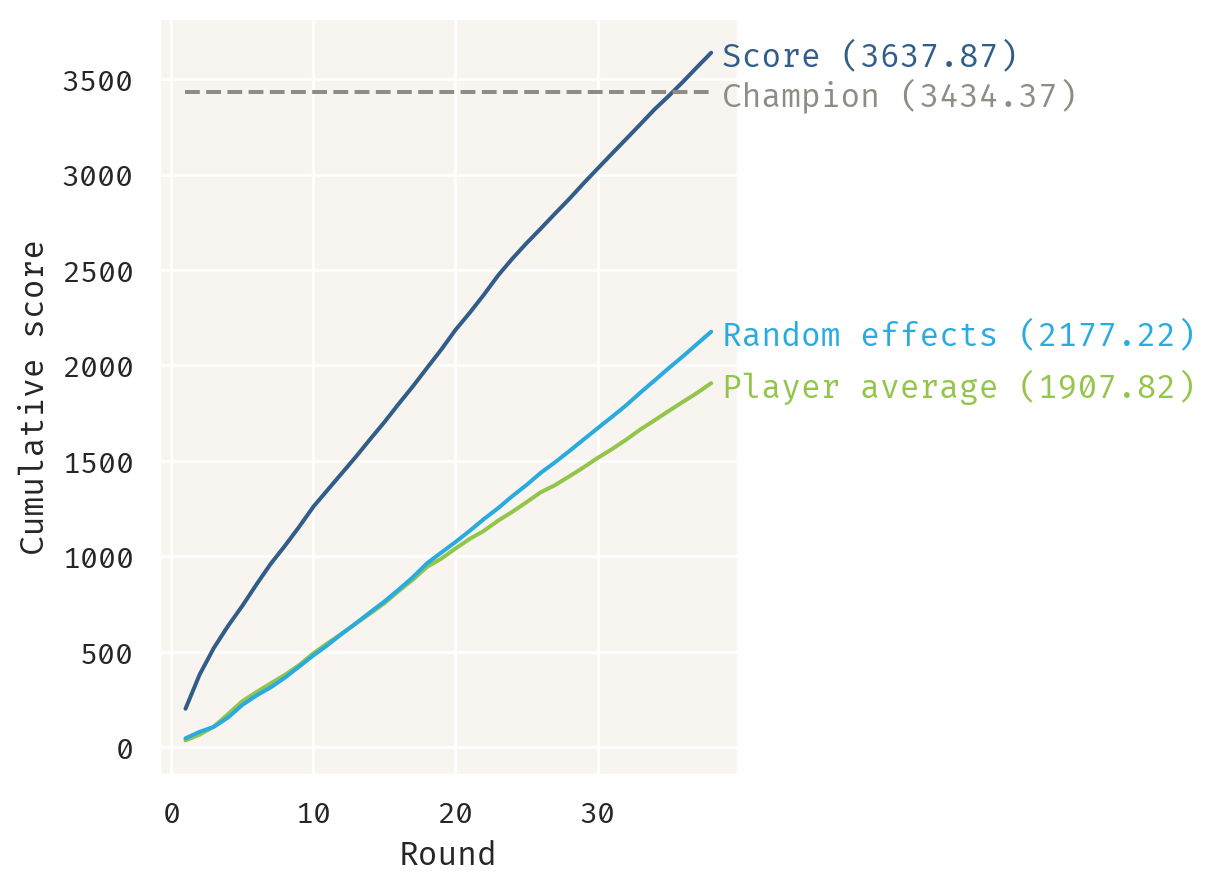

In [18]:
# | label: score-prediction-player-random-effects
# | message: false
# | warning: false
from functools import partial
import arviz as az
import bambi as bmb


def predict_model(
    data: pl.DataFrame, candidates: pl.DataFrame, **kwargs
) -> pl.DataFrame:
    if data.height == 0:
        predictions = candidates.get_column("value")
    else:
        model = bmb.Model(data=data.to_pandas(), **kwargs)
        inference = model.fit(
            inference_method="nuts_numpyro", random_seed=37, progressbar=False
        )
        predictions = model.predict(
            inference,
            data=candidates.to_pandas(),
            sample_new_groups=True,
            inplace=False,
        )
        summary = az.summary(predictions, var_names=["score_mean"])
        predictions = summary["mean"].values
    candidates = candidates.with_columns(prediction=pl.lit(predictions))
    return candidates


predict_random_effects = partial(predict_model, formula="score ~ (1 | player)")
teams = backtest(players, predict_random_effects)
fig = add_backtest(fig, teams, "Random effects")
fig

### Fixture mixed effects

$$
\mathbf{\hat{s}} = \alpha + \mathbf{X} \mathbf{\beta} + \mathbf{Z} \mathbf{b},
$$

where
$\mathbf{X}$ is a matrix of the dummy-encoded fixture variables: the player
    `team`, whether they are playing at `home`, and their `adversary` team
    variables;
$\mathbf{\beta}$ is a vector of fixed effects.

This model brings more context to our predictions. It also provides a reasonable
way to predict a new player, by setting their $b = 0$ (the mean of the random
effects). However, it does not improve significantly over our random effects
model.

Compiling...
Compilation time = 0:00:07.905601
Sampling...
Sampling time = 0:00:40.474963
Transforming variables...
Transformation time = 0:00:00.101650
Compiling...
Compilation time = 0:00:02.563196
Sampling...
Sampling time = 0:00:15.965689
Transforming variables...
Transformation time = 0:00:00.081567
Compiling...
Compilation time = 0:00:01.121964
Sampling...
Sampling time = 0:00:06.425227
Transforming variables...
Transformation time = 0:00:00.088375
Compiling...
Compilation time = 0:00:01.109532
Sampling...
Sampling time = 0:00:07.657055
Transforming variables...
Transformation time = 0:00:00.085445
Compiling...
Compilation time = 0:00:01.138635
Sampling...
Sampling time = 0:00:08.078478
Transforming variables...
Transformation time = 0:00:00.084024
Compiling...
Compilation time = 0:00:01.142378
Sampling...
Sampling time = 0:00:10.012693
Transforming variables...
Transformation time = 0:00:00.080147
Compiling...
Compilation time = 0:00:01.494229
Sampling...
Sampling time = 0:00:10

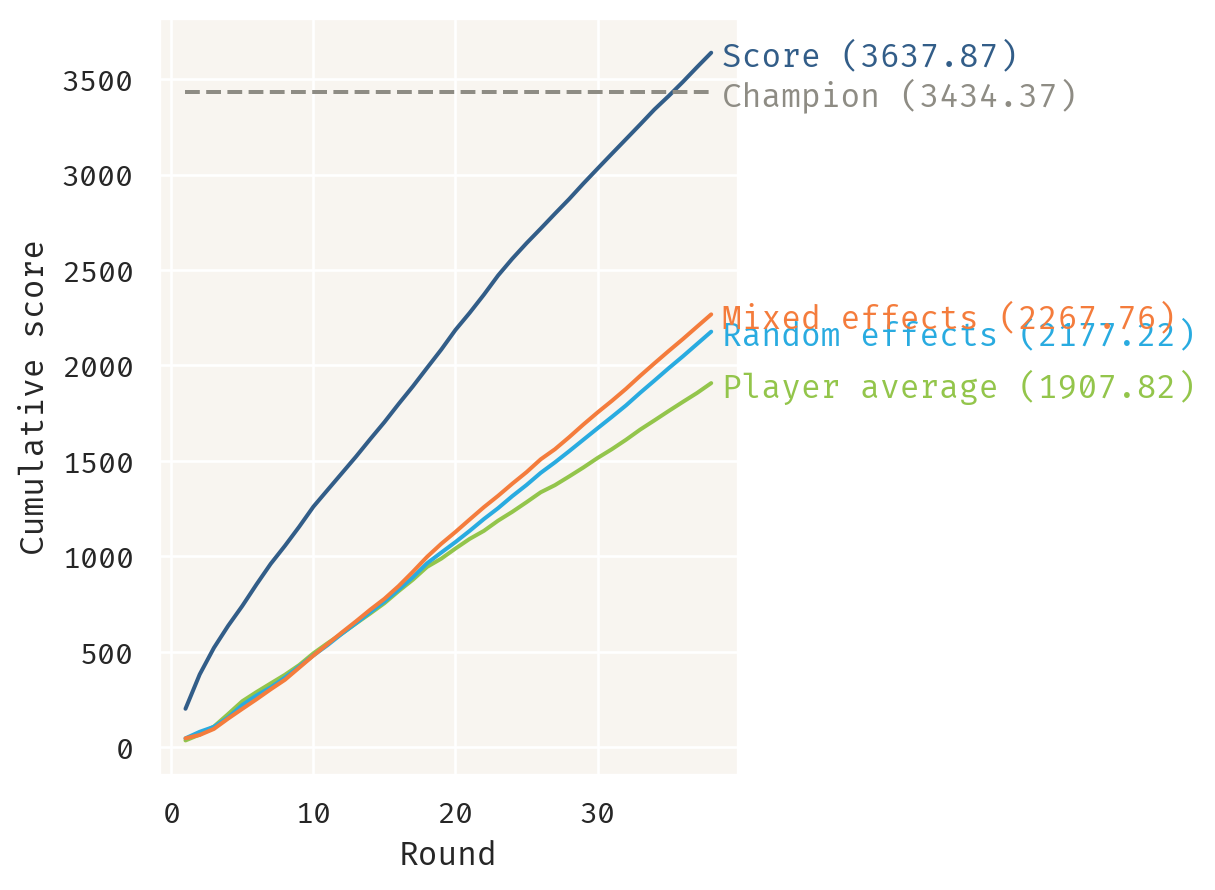

In [19]:
# | label: score-prediction-fixture-mixed-effects
# | message: false
# | warning: false
predict_mixed_effects = partial(
    predict_model,
    formula="score ~ home + C(team) + C(versus) + (1 | player)",
)
teams = backtest(players, predict_mixed_effects)
fig = add_backtest(fig, teams, "Mixed effects")
fig

## Conclusion

We developed a comprehensive framework for the fantasy football team picking
problem. There are more ideas we could explore to improve our chances of
winning:

* enriching our data and models with player scouts;
* including more information in our priors;
* testing strategies that balance predicted score and appreciation;
* further model diagnostics.

However, I suppose expert human player predictions have a certain edge over
those of hobbyist statistical models in fantasy leagues, due to the fact that
there are all sorts of relevant data unavailable in public datasets.

At least, this seems to be the case for brazilian soccer, also known as "a
little box of surprises".